<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Positional_Trading_with_Auto_Regression_Finite_Horizon_Forecast_(Linear_Algebra).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker = 'NIFTYBEES.NS'
prev_day = 0
scale_factor = 365 * 100

ar_p = 200
ar_h = 50

num_paths = 1000
paths_to_plot = 5

risk_budget = 100
max_fund = 10000

In [4]:
entity = {}

In [5]:
def download_data(entity, ticker):
    print(f"Downloading {ticker}")

    # Download intraday data with a 1-minute interval.
    data = yf.download(ticker, period="5y", interval="1d")

    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    data.index = data.index.tz_convert('Asia/Kolkata')

    data_ = pd.DataFrame({
        'S' : data['Close'].values.reshape((-1,))
    }, index = data.index)

    entity['data'] = data_

In [6]:
def calculate_return(entity):
    data = entity['data']

    data.eval('log_S = log(S)', inplace = True)
    data['r'] = scale_factor * data['log_S'].diff()

In [7]:
def split_data(entity):
    entity['train'] = entity['data'].iloc[:-ar_h]
    entity['test'] = entity['data'].iloc[-ar_h:]

In [8]:
def feature_engg(entity):
    data = entity['train']

    features_df = data[['S', 'r']]
    features_df.eval('x = (r - r.mean())/r.std()', inplace = True)

    features_df['x'] = (features_df['r'] - features_df['r'].mean())/features_df['r'].std()

    for idx in range(ar_p):
        features_df[f'x_m{idx + 1}'] = features_df['x'].shift(idx + 1)

    for idx in range(ar_h):
        features_df[f'x_p{idx}'] = features_df['x'].shift(-idx)


    features_df.dropna(inplace = True)

    entity['features'] = features_df

    entity['features_train_x'] = entity['features'][[f'x_m{idx + 1}' for idx in range(ar_p)]]
    entity['features_train_y'] = entity['features'][[f'x_p{idx}' for idx in range(ar_h)]]

    #for idx in range(ar_p):
    #    for jdx in range(idx + 1):
    #        entity['features_train_x'].eval(f'x_{idx+1}_{jdx+1} = x_m{idx+1} * x_m{jdx+1}', inplace = True)

In [9]:
def fit_model(entity):
    A = np.matmul(entity['features_train_x'].T, entity['features_train_x'])
    b = np.matmul(entity['features_train_x'].T, entity['features_train_y'])
    inv_A = pd.DataFrame(la.inv(A), columns = A.columns, index = A.index)
    entity['weights'] = np.matmul(inv_A, b)
    mean_x = pd.DataFrame({'Intercept' : entity['features_train_x'].mean()}).T
    mean_y = pd.DataFrame({'Intercept' : entity['features_train_y'].mean()}).T
    intercept = mean_y - np.matmul(mean_x, entity['weights'])
    entity['intercept'] = intercept
    entity['residue'] = entity['features_train_y'] - np.matmul(entity['features_train_x'], entity['weights'])

    dof = len(entity['features_train_x']) - len(entity['weights'])
    sigma_df = pd.DataFrame({'sigma' : np.sqrt((entity['residue']**2).sum()/dof)})

    entity['params'] = pd.concat([intercept, entity['weights'], sigma_df.T])

In [10]:
def test_forecast(entity):
    mean = np.matmul(entity['features_train_x'].iloc[-1:], entity['params'].iloc[1 :-1]) + entity['params'].iloc[0]
    sigma = entity['params'].iloc[-1:]

    entity['test_forecast_x'] = pd.DataFrame(
        data = np.random.normal(loc = mean, scale = sigma, size = (num_paths, ar_h)),
        columns = entity['features_train_y'].columns
    )

    entity['test_forecast'] = entity['test_forecast_x'] * entity['train']['r'].std() + entity['train']['r'].mean()
    entity['test_forecast'].columns = entity['test'].index
    entity['test_forecast'].index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    entity['test_forecast'] = entity['test_forecast'].T

    init_S_df = entity['train'].iloc[-1:][['S']]
    init_forecast_df = pd.DataFrame(np.zeros_like(entity['test_forecast'].iloc[:1]), columns = entity['test_forecast'].columns, index = init_S_df.index)
    entity['test_forecast'] = pd.concat([init_forecast_df, entity['test_forecast']])/scale_factor
    entity['test_forecast_price'] = init_S_df.iloc[0, 0] * entity['test_forecast'].cumsum().apply(np.exp)

    entity['test_monte_carlo_quantiles'] = entity['test_forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['test_monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [11]:
def trading_strategy(entity):
    long_risk_level = entity['test_monte_carlo_quantiles']['low_ci'].min()
    short_risk_level = entity['test_monte_carlo_quantiles']['high_ci'].max()

    entity['strategy'] = entity['test'][['S']]

    entity['strategy'].eval('var = 100 * (S - @long_risk_level)/S', inplace = True)
    entity['strategy'].update(entity['strategy'].query('var < 0').eval('var = 0'))
    entity['strategy'].eval('var_level = floor(var + 0.5)', inplace = True)

    entity['strategy'].eval('position_size = 100 * @risk_budget / var_level', inplace = True)
    entity['strategy'].eval('units = floor(position_size / S + 0.5)', inplace = True)
    entity['strategy'].update(entity['strategy'].query('position_size >= 0.8 * @max_fund').eval('units = 0'))

    entity['strategy']['delta_units'] = entity['strategy']['units'].diff()
    entity['strategy']['delta_units'].iloc[0] = entity['strategy']['units'].iloc[0]



In [12]:
def main(entity):
    download_data(entity, ticker)
    calculate_return(entity)
    split_data(entity)
    feature_engg(entity)
    fit_model(entity)
    test_forecast(entity)
    trading_strategy(entity)

In [13]:
if __name__ == '__main__':
    main(entity)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


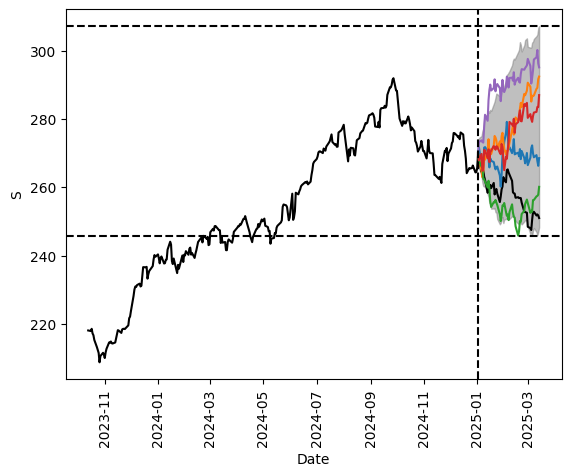

In [14]:
selected_paths = np.random.choice(entity['test_forecast_price'].columns, paths_to_plot, replace=False)

sns.lineplot(x = 'Date', y = 'S', data = entity['data'].iloc[-350:].reset_index(), color = 'black')

for p in selected_paths:
    sns.lineplot(x = 'Date', y = p, data = entity['test_forecast_price'].reset_index())

plt.fill_between(entity['test_monte_carlo_quantiles'].index, entity['test_monte_carlo_quantiles']['low_ci'], entity['test_monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
plt.axhline(entity['test_monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
plt.axhline(entity['test_monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
plt.axvline(entity['test_monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')
_ = plt.xticks(rotation=90)

In [15]:
entity['strategy']

,S,var,var_level,position_size,units,delta_units
Date,,,,,,
2025-01-03 05:30:00+05:30,268.410004,8.424997,8.0,1250.000000,5.0,5.0
2025-01-06 05:30:00+05:30,264.480011,7.064255,7.0,1428.571429,5.0,0.0
2025-01-07 05:30:00+05:30,265.160004,7.302585,7.0,1428.571429,5.0,0.0
2025-01-08 05:30:00+05:30,264.920013,7.218611,7.0,1428.571429,5.0,0.0
2025-01-09 05:30:00+05:30,263.149994,6.594538,7.0,1428.571429,5.0,0.0
2025-01-10 05:30:00+05:30,262.220001,6.263265,6.0,1666.666667,6.0,1.0
2025-01-13 05:30:00+05:30,258.399994,4.877525,5.0,2000.000000,8.0,2.0
2025-01-14 05:30:00+05:30,259.260010,5.193065,5.0,2000.000000,8.0,0.0
2025-01-15 05:30:00+05:30,259.579987,5.309931,5.0,2000.000000,8.0,0.0
